## Importing Necessary Libraries and Making Initial Configurations
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

import math

## Loading Audio Files
---

### Initial Sound File Prune

- Sound files with an emotion identification rate less than 50% were not included

### Filename identifiers

 - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

 - Vocal channel (01 = speech, 02 = song).
 
 - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
 
 - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
 
 - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
 
 - Repetition (01 = 1st repetition, 02 = 2nd repetition).
 
 - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

### RAVDESS Sampling Function

 - allows for customized querying of the RAVDESS dataset based on desired feature types


In [2]:
# takes path of directory containing all actor subdirectories
# tuples are used to specify the desired types for each feature
#   default is set to include everything
def get_RAVDESS_sample(path, modality: tuple = (1,2,3),
                             voice_channel: tuple = (1,2),
                             emotion: tuple = tuple(range(1,9)),
                             intensity: tuple = (1,2),
                             statement: tuple = (1,2),
                             actor: tuple = tuple(range(1,25))):
    
    m = "".join(str(s) for s in modality)
    vc = "".join(str(s) for s in voice_channel)
    e = "".join(str(s) for s in emotion)
    i = "".join(str(s) for s in intensity)
    s = "".join(str(s) for s in statement)

    actor = set(actor)
    
    dirs = []
    
    if(path[-1] == '/'):
        adirs = path+"Actor_*"
    else:
        adirs = path+"/Actor_*"
                
    for d in glob(adirs):
        if (int(d[-2]+d[-1]) in actor):
            dirs.append(d)

    files = []
    for d in dirs:
        d = d+"/"
        
        for f in glob(d+f"0[{m}]-0[{vc}]-0[{e}]-0[{i}]-0[{s}]-01-*"):    
            files.append(f)
    
    return files

    

### Sampling Method

The goal was to extract a sample from the dataset that was significantly smaller in size and computationally inexpensive, while preserving the original dataset's variability.

All emotional variations and intensities for the first repetition of a single statement were extracted. For statement 1, data came from the first half of the dataset (Actors 1-12), and for statement 2 data came from the second half (Actors 13-24). This ensured that variability across emotion type, emotional intensity and actor gender was retained. Furthermore, the inclusion of only one repitition for all statements and the consideration of only a single statement type for each actor resulted in a 4-fold reduction in sample size.

In [3]:
# all variations of statement 1 for the first 12 actors
audio_files = get_RAVDESS_sample("./sound_files", (3,), (1,), statement=(1,), actor=list(range(1,13)))

# all variations of statement 2 for the second 12 actors
audio_files.extend(get_RAVDESS_sample("./sound_files", (3,), (1,), statement=(2,), actor=list(range(13,25))))

# printing number of audio files that will be processed
print(len(audio_files))

360


In [4]:
# loading audio file using librosa
digital_signal, sample_rate = librosa.load(audio_files[15], sr=None, mono=True)
print(f"number of samples: {len(digital_signal)}")
print(f"original sample rate: {sample_rate}/s")
print(f"audio duration: {len(digital_signal)/sample_rate}")

number of samples: 193793
original sample rate: 48000/s
audio duration: 4.037354166666667


## Preparing and Analyzing Audio Files
---

### Removing Leading and Trailing Silences from Audio Files



### Normalizing Sample by Average Power Level

The average power level of a digital signal is the sum of all its samples divided by the number of samples. To normalize, we determine the average power level of each audio file in the sample dataset and then calculate the overall mean of all averages. Each digital signal in the sample was the downscaled or upscaled so that its average power was equal to this grand mean.

In [5]:
def plot_signal(signal, sample_rate, plot_title = "Audio Signal"):
    df = pd.DataFrame({
        'signals' : signal,
        'seconds' : [i/sample_rate for i in range(0, len(signal))]
    })
    df.plot(y="signals", x="seconds", figsize=(15,5), lw=0.1, title=plot_title, xlabel="seconds", ylabel="amplitude")

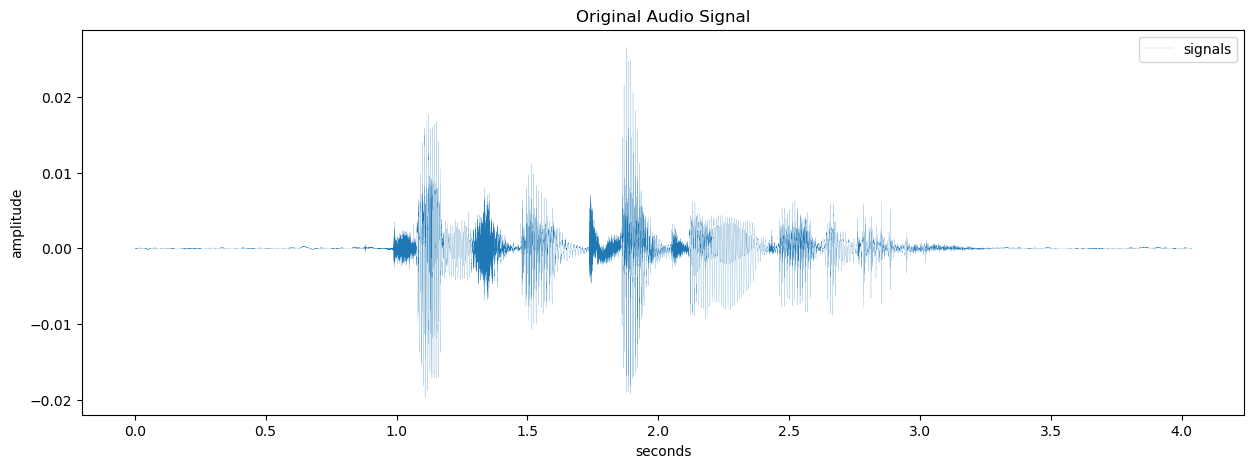

In [14]:
# plotting digital signal
plot_signal(digital_signal, sample_rate, "Original Audio Signal")
ipd.Audio(digital_signal, rate=sample_rate)

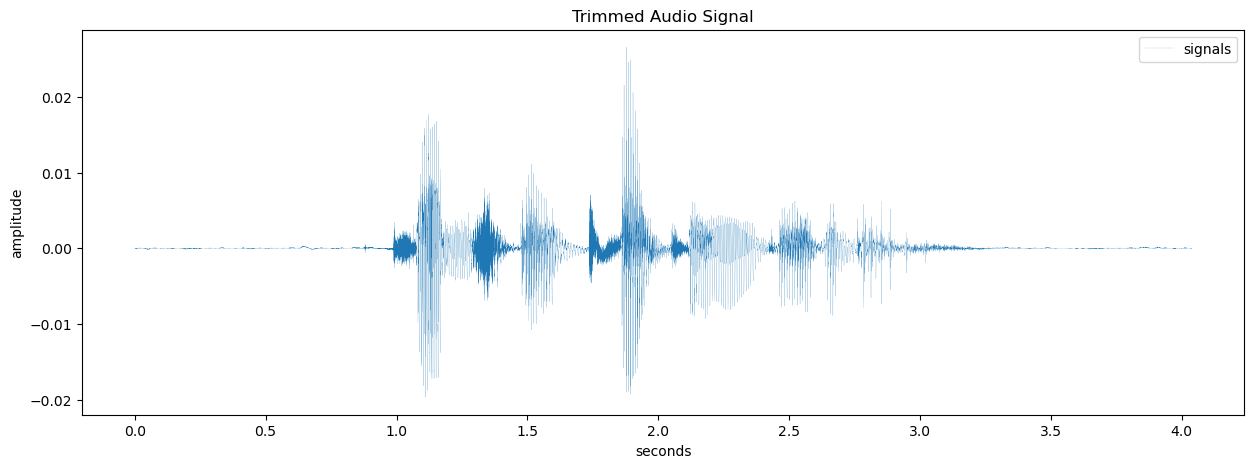

In [29]:
# trimmed signal
db = 20 * math.log10( (0.95*max(digital_signal)) / max(digital_signal) )
trimed_signal, _ = librosa.effects.trim(digital_signal, top_db=100000)
plot_signal(trimed_signal, sample_rate, "Trimmed Audio Signal")
ipd.Audio(trimed_signal, rate=sample_rate)

## Adding Noise
---

In [8]:
# noise generation functions

def generate_white_noise_gaussian(length, std_dev=0.1):
    return np.random.normal(0, std_dev, length)

def generate_white_noise_uniform(length):
    return np.random.uniform(-1,1,length)


# mixing function

def add_noise(noise_type, signal, snr=1):
    
    signal_len = len(signal)
    signal_power = np.sum(signal**2)/signal_len
    signal_std_dev = np.std(signal)
    
    if noise_type == 'n':
        noise = generate_white_noise_gaussian(signal_len, signal_std_dev)
    else:
        noise = generate_white_noise_uniform(signal_len)
    
    noise_power = np.sum(noise**2)/signal_len
    scale_factor = math.sqrt( (signal_power/noise_power)*(10**(-snr/10)) )
    
    noise *= scale_factor
    noisy_audio = noise + signal
    
    return noisy_audio
    

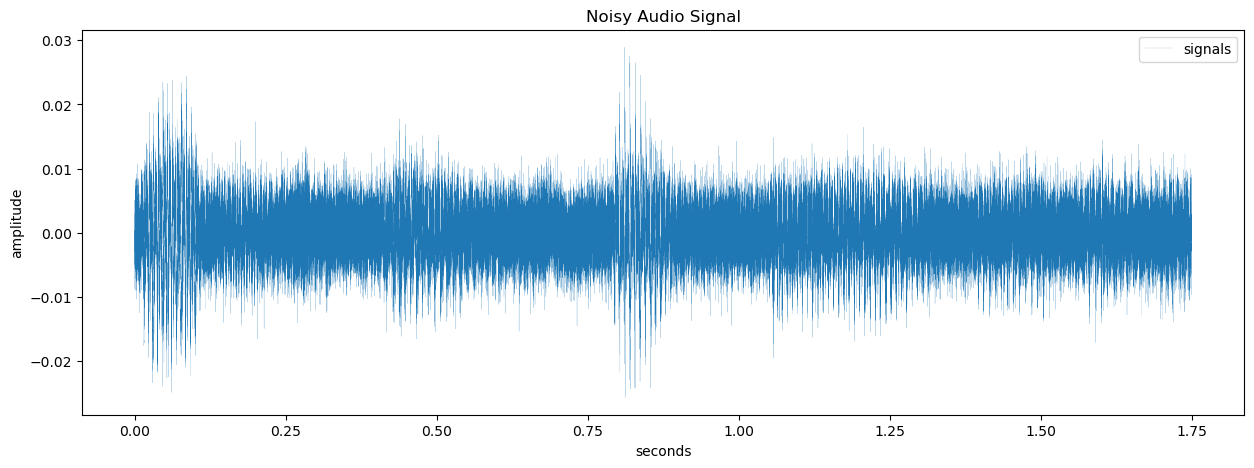

In [9]:
# requesting desired signal to noise ratio
snr = input("Please enter the required signal to noise ratio")
snr = int(snr)

# generating noisy audio
choice = input("Enter 'n' for gaussian white noise or 'u' for uniform white noise")

noisy_audio = add_noise(choice, trimed_signal, snr=snr)    
plot_signal(noisy_audio, sample_rate, "Noisy Audio Signal")
ipd.Audio(noisy_audio, rate=sample_rate)